In [159]:
import xarray as xr
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import numpy.typing as npt
from typing import Tuple
import skgstat as skg
from grid_funcs import sign_add, block_mean_loop
from grid import open_mult

In [160]:
PROCESSED = Path("data")
# files = PROCESSED.glob("2005*.nc")
# fc = [netcdf.netcdf_file(file) for file in files]
file = PROCESSED / Path("EREEFS_AIMS-CSIRO_GBR4_H2p0_B3p1_Cq3P_Dhnd_bgc_annual-annual-sed-2010.nc")
# data_right = xr.open_dataset(file.as_posix(),engine="netcdf4")
ourfile1 = Path("Processed","all","2005_7_4.nc")
ourfile2 = Path("Processed","all","2005_7_5.nc")
ourfile3 = Path("Processed","all","2005_7_6.nc")
ourfiles = [ourfile1,ourfile2,ourfile3]
# data_our = xr.open_dataset(ourfile.as_posix(),engine="netcdf4")

In [161]:
def block_mean(x_boundary: Tuple[float, float],y_boundary: Tuple[float, float],data_path: Path) -> npt.NDArray[np.float64]:
    """mean grid in blocks of resolution size"""
    # data = xr.open_dataset(data_path, engine="netcdf4")
    data = open_mult(data_path)
    data_lon,data_lat = data["lon"].values, data["lat"].values
    vals = data.sla.values
    resolution = 1

    x_start=sign_add(x_boundary[0], resolution/2)
    x_end=sign_add(x_boundary[1], resolution/2)
    lons = np.arange(x_start,x_end,resolution)
    y_start=sign_add(y_boundary[0], resolution/2)
    y_end=sign_add(y_boundary[1], resolution/2)
    lats = np.arange(y_start,y_end,resolution)
    x_size = int((x_end-x_start)//resolution)
    y_size = int((y_end-y_start)//resolution)

    block_mean = block_mean_loop(x_size,y_size,resolution,x_start,y_start,data_lon,data_lat,vals)

    if len(lons) != block_mean.shape[1]:
        lons = lons[:-1]
    if len(lats) != block_mean.shape[0]:
        lats = lats[:-1]
    return block_mean, lons, lats

In [163]:
# datalon = data_our["lon"].values
# datalat = data_our["lat"].values
# dataz = data_our["sla"].values

block_grid, grid_lons, grid_lats = block_mean((-180,180),(-80,80),ourfiles)

nidx = ~np.isnan(block_grid)
grid_lon, grid_lat = np.meshgrid(grid_lons, grid_lats)
grid_lons, grid_lats, block_grid = grid_lon[nidx], grid_lat[nidx], block_grid[nidx]

coords = np.vstack((grid_lons, grid_lats)).T

In [164]:
V = skg.Variogram(coords,block_grid)

c:\Users\mathi\mambaforge\envs\grid\lib\site-packages\skgstat\plotting\variogram_plot.py:123: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


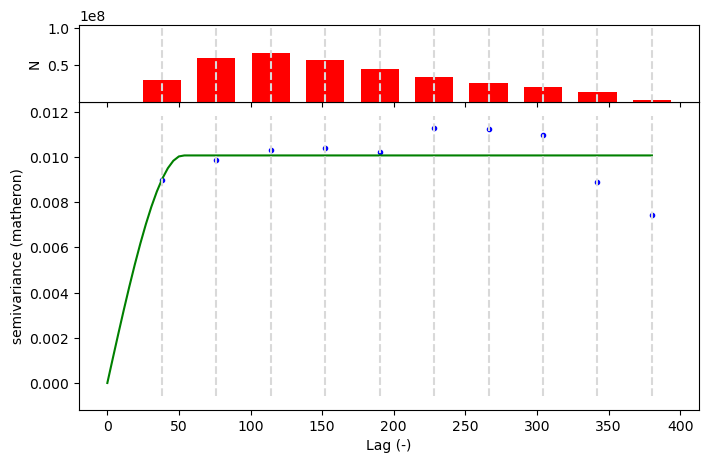

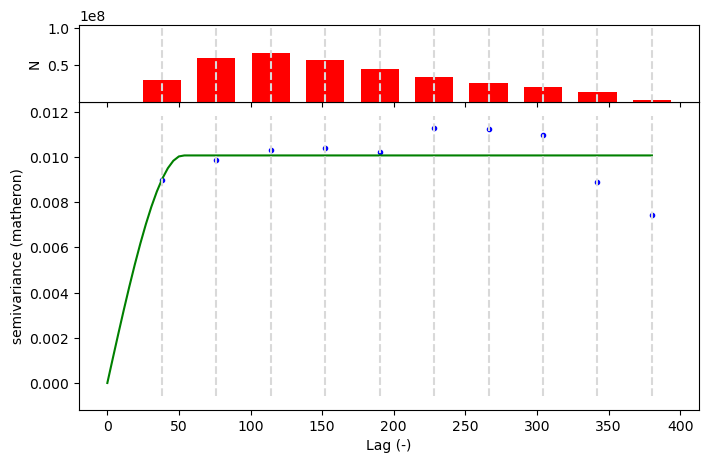

In [165]:
V.plot()

In [166]:
ok = skg.OrdinaryKriging(V,min_points=3,max_points=5,mode='estimate')

In [226]:
xx,yy = np.meshgrid(np.arange(-180,180),np.arange(-80,80))
field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
s2 = ok.sigma.reshape(xx.shape)

In [228]:
landmask = xr.open_dataset("data/land_NaN_01d.grd").z.data
kri = landmask[10:-10]*field
err = landmask[10:-10]*s2

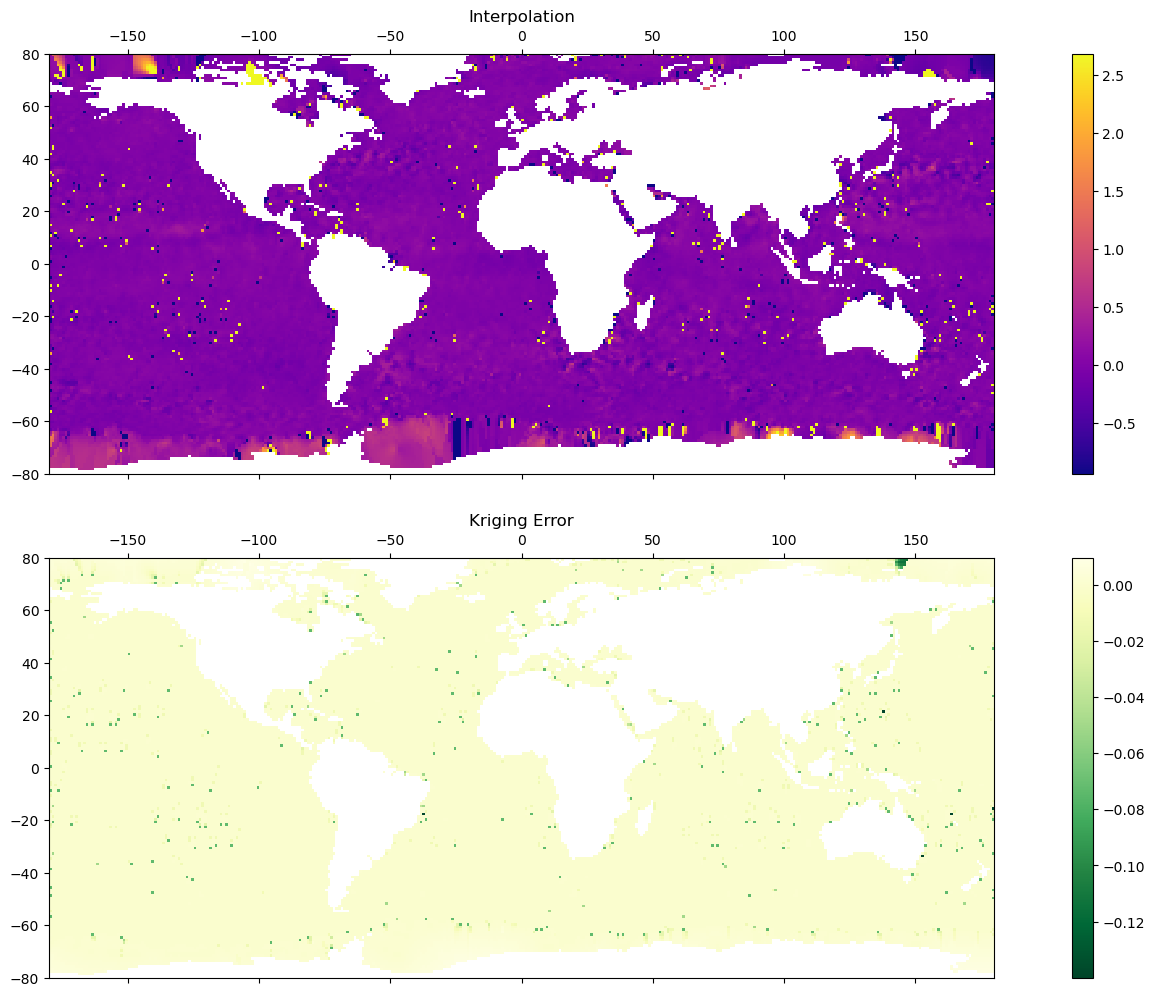

In [231]:
fig, axes = plt.subplots(2, 1, figsize=(20, 12))
art = axes[0].matshow(kri, origin='lower', cmap='plasma',extent=[-180,180,-80,80],vmin=block_grid.min(),vmax=block_grid.max())
# axes[0].imshow(field.T,origin='lower')
axes[0].set_title('Interpolation')
# axes[0].scatter(coords[:,0], coords[:,1], c=block_grid,s=1,cmap="plasma",vmin=block_grid.min()+0.3,vmax=block_grid.max()-0.3)

plt.colorbar(art, ax=axes[0])
art = axes[1].matshow(err, origin='lower', cmap='YlGn_r',extent=[-180,180,-80,80])
axes[1].set_title('Kriging Error')
plt.colorbar(art, ax=axes[1])
# axes[1].scatter(coords[:,0], coords[:,1], color=(0,0,0,0.1),s=1)

plt.show()

In [23]:
data_tmp = xr.Dataset(
    data_vars=dict(
        sla=(["latitude","longitude"],block_grid)
    ),
    coords=dict(
        longitude=("longitude",grid_lons),
        latitude=("latitude",grid_lats),
    ),
    attrs=data_our.attrs
)
data_tmp.to_netcdf("Grids/test_QGIS.nc",mode="w")

In [22]:
data_tmp

<xarray.Dataset>
Dimensions:    (latitude: 959, longitude: 2159)
Coordinates:
  * latitude   (latitude) float64 -79.92 -79.75 -79.58 ... 79.42 79.58 79.75
  * longitude  (longitude) float64 -179.9 -179.8 -179.6 ... 179.4 179.6 179.7
Data variables:
    sla        (latitude, longitude) float64 nan nan nan nan ... nan nan nan nan
Attributes: (12/13)
    Conventions:           CF-1.7
    title:                 RADS 4 pass file
    institution:           EUMETSAT / NOAA / TU Delft
    source:                radar altimeter
    references:            RADS Data Manual, Version 4.2 or later
    featureType:           trajectory
    ...                    ...
    ellipsoid_axis:        6378136.3
    ellipsoid_flattening:  0.0033528131778969143
    mission_name:          ['JASON-1', 'TOPEX', 'ERS-2', 'ENVISAT1', 'GFO-1']
    mission_phase:         ['a', 'a', 'a', 'b', 'a']
    n_points:              [49230 38056  5812 39716 48419]
    total_points:          181233

In [160]:
# idx = 
result = interp(block_grid,grid_lons,grid_lats,gridlon,gridlat,order=1)

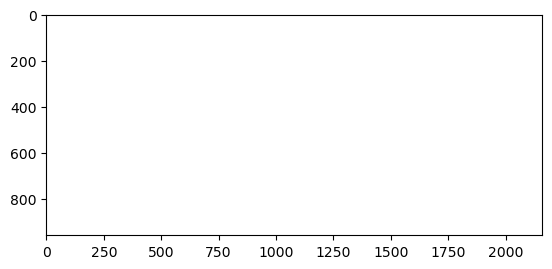

In [161]:
plt.imshow(result)
plt.show()